In [1]:
import matplotlib.gridspec as gridspec
import scqubits
import numpy as np
from CoupledQuantumSystems.visualization import *
from CoupledQuantumSystems.systems import *
from tqdm import tqdm
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from  IPython.display import  clear_output

In [2]:
max_ql = 13
EJ_over_EC = 2
EJ_over_EL = 30
fluxonium = scqubits.Fluxonium(EJ = 4,EC = 4/EJ_over_EC,EL = 4/EJ_over_EL, cutoff = 110,flux = 0,truncated_dim=max_ql)

In [3]:
max_tl = 4
transmon = scqubits.Transmon(
    EJ= 50.252,
    EC=0.5,
    ng=0.0,
    ncut=10,
    truncated_dim = max_tl
    )

system = FluxoniumTransmonSystem(
    fluxonium  = fluxonium,
    transmon = transmon,
    computaional_states = '0,2',
    g_strength = 0.1,
    )
driven_op = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(transmon.n_operator)[:, :])

e_ops = []
for ql in range(max_ql):
    for tl in range(max_tl):
        e_ops.append(system.truncate_function(qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,tl)]))))


 Total run time:   0.88s*] Elapsed 0.88s / Remaining 00:00:00:00 [*********96%********** ] Elapsed 0.86s / Remaining 00:00:00:00
 Total run time:   0.88s*] Elapsed 0.88s / Remaining 00:00:00:00
 Total run time:   0.90s*] Elapsed 0.90s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 500/500 [00:00<00:00, 8338.51it/s]


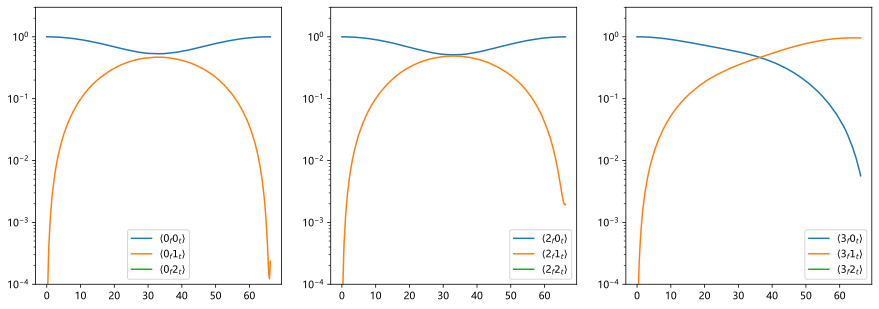

In [4]:
amp = 0.049698  / (2*np.pi)
t = 66.2
tlist = np.linspace(0,t,500)
results  = system.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,3]],
    tlist = tlist,
    drive_terms = [DriveTerm( 
                            driven_op= driven_op,
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_id = 'sdaas',
                            pulse_shape_args={
                                'w_d': system.evals[system.product_to_dressed[(3,1)]] - system.evals[system.product_to_dressed[(3,0)]] ,
                                'amp': amp,
                                't_square': 1000
                            })],
    # c_ops = c_ops,
    e_ops =  e_ops
)

fig, axes = plt.subplots(1,3,figsize = (15,5))
for i, (result,ql) in enumerate(zip(results,[0,2,3])):
    axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql}$_f0_t\rangle$")
    axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql}$_f1_t\rangle$")
    axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql}$_f2_t\rangle$")
    axes[i].legend()
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-4,1+2)
    # axes[i].set_xlim(0,102)
plt.show()

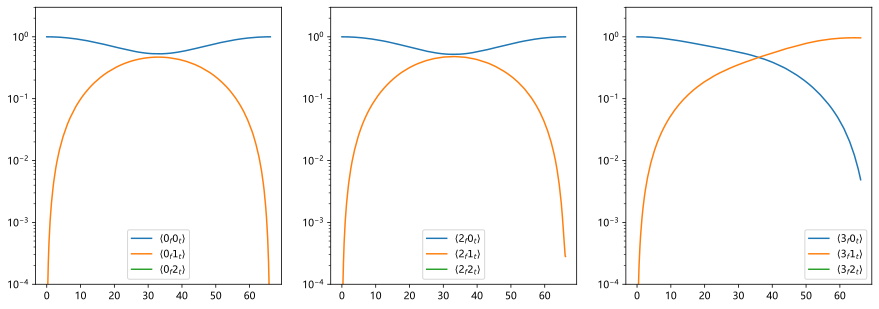

x = [5.02534488e+01 7.93291212e-03 6.61411010e+01], obj  = -1.9994195926195746
 Total run time:   0.99s*] Elapsed 0.99s / Remaining 00:00:00:00 [*********96%********** ] Elapsed 0.96s / Remaining 00:00:00:00
 [*********97%********** ] Elapsed 0.98s / Remaining 00:00:00:00

Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:00<00:00, 8593.46it/s]


 Total run time:   1.01s*] Elapsed 1.01s / Remaining 00:00:00:00 [*********92%*********  ] Elapsed 0.96s / Remaining 00:00:00:00
 Total run time:   1.04s*] Elapsed 1.04s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:00<00:00, 8532.88it/s]


KeyboardInterrupt: 

In [5]:
from scipy.optimize import minimize

def objective(x):
    
    EJ = x[0]
    amp = x[1]
    t_duration = x[2]
    tlist = np.linspace(0,t_duration,1000)

    transmon = scqubits.Transmon(
        EJ= EJ,
        EC=0.5,
        ng=0.0,
        ncut=10,
        truncated_dim = max_tl
        )

    system = FluxoniumTransmonSystem(
        fluxonium  = fluxonium,
        transmon = transmon,
        computaional_states = '0,2',
        g_strength = 0.1,
        )
    driven_op = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(transmon.n_operator)[:, :])

    e_ops = []
    for ql in range(max_ql):
        for tl in range(max_tl):
            e_ops.append(system.truncate_function(qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,tl)]))))

    results  = system.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,3]],
        tlist = tlist,
        drive_terms = [DriveTerm( 
                            driven_op= driven_op,
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_id = 'sdaas',
                            pulse_shape_args={
                                'w_d': system.evals[system.product_to_dressed[(3,1)]] - system.evals[system.product_to_dressed[(3,0)]] ,
                                'amp': amp,
                                't_square': 1000
                            })],
        # c_ops = c_ops,
        e_ops =  e_ops
    )
    
    fig, axes = plt.subplots(1,3,figsize = (15,5))
    for i, (result,ql) in enumerate(zip(results,[0,2,3])):
        axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql}$_f0_t\rangle$")
        axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql}$_f1_t\rangle$")
        axes[i].plot(tlist,result.expect[ql*max_tl+2],label= rf"$\langle${ql}$_f2_t\rangle$")
        axes[i].legend()
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-4,1+2)
    clear_output()
    plt.show()
    obj =  -results[0].expect[0*max_tl+0][-1] ** 2 \
            -results[1].expect[2*max_tl+0][-1] ** 2\
            + results[2].expect[3*max_tl+0][-1] ** 2 / 50
    print(f"x = {x}, obj  = {obj}")
    return obj


initial_guess = [50.252 ,0.049698  / (2*np.pi) , 66.2]

 
result = minimize(objective, initial_guess, method='Nelder-Mead')

objective(initial_guess)

In [6]:
x = [5.02534400e+01 ,7.93221262e-03,6.61325229e+01]

EJ = x[0]
amp = x[1]
t_duration = x[2]
tlist = np.linspace(0,t_duration,1000)

transmon = scqubits.Transmon(
    EJ= EJ,
    EC=0.5,
    ng=0.0,
    ncut=10,
    truncated_dim = max_tl
    )

system = FluxoniumTransmonSystem(
    fluxonium  = fluxonium,
    transmon = transmon,
    computaional_states = '0,2',
    g_strength = 0.1,
    )
driven_op = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(transmon.n_operator)[:, :])

e_ops = []
for ql in range(max_ql):
    for tl in range(max_tl):
        e_ops.append(system.truncate_function(qutip.ket2dm(qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,tl)]))))

results  = system.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(system.hilbertspace.dimension, system.product_to_dressed[(ql,0)]) for ql in [0,2,3,1]],
    tlist = tlist,
    drive_terms = [DriveTerm( 
                        driven_op= driven_op,
                        pulse_shape_func=square_pulse_with_rise_fall,
                        pulse_id = 'sdaas',
                        pulse_shape_args={
                            'w_d': system.evals[system.product_to_dressed[(3,1)]] - system.evals[system.product_to_dressed[(3,0)]] ,
                            'amp': amp,
                            't_square': 1000
                        })],
    # c_ops = c_ops,
    e_ops =  e_ops
)


 Total run time:   0.98s*] Elapsed 0.98s / Remaining 00:00:00:00 [*********93%*********  ] Elapsed 0.91s / Remaining 00:00:00:00
 [*********98%***********] Elapsed 1.00s / Remaining 00:00:00:00 [*********89%********   ] Elapsed 0.90s / Remaining 00:00:00:00

Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:00<00:00, 8743.96it/s]


 Total run time:   1.03s*] Elapsed 1.03s / Remaining 00:00:00:00[*********97%********** ] Elapsed 0.95s / Remaining 00:00:00:000
 Total run time:   0.99s*] Elapsed 0.99s / Remaining 00:00:00:00
 Total run time:   1.02s*] Elapsed 1.02s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:00<00:00, 7711.17it/s]


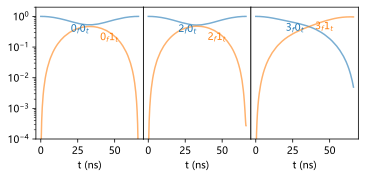

In [7]:
fig = plt.figure(figsize=(5, 2.3)) 
bottom = 0.15
top = 0.95
left = 0.15
l = 0.3

gs0 = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+l,
                       bottom=bottom,top = top)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=left+l, right=left+l*2,
                       bottom=bottom,top = top)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=left+l*2, right=left+l*3,
                       bottom=bottom,top = top)

axes = [fig.add_subplot(gs0[0]),
        fig.add_subplot(gs1[0]),
        fig.add_subplot(gs2[0])]

alpha=0.6
for i, (result,ql) in enumerate(zip(results,[0,2,3])):
    line, =axes[i].plot(tlist,result.expect[ql*max_tl+0],label= rf"$\langle${ql}$_f0_t\rangle$",alpha=alpha)
    axes[i].text(tlist[400],result.expect[ql*max_tl+0][400],s= rf"{ql}$_f0_t$",va='top',ha='center',color=line.get_color())

    line, =axes[i].plot(tlist,result.expect[ql*max_tl+1],label= rf"$\langle${ql}$_f1_t\rangle$",alpha=alpha)
    axes[i].text(tlist[-300],result.expect[ql*max_tl+1][-300],s= rf"{ql}$_f1_t$",va='top',ha='center',color=line.get_color())

    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-4,2)

for i in [0,1,2]:
    axes[i].set_xlabel(f"t (ns)")

for i in [1,2]:
    axes[i].yaxis.set_visible(False)


plt.show()
fig.savefig('detect3.pdf')